<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: аналитик-разработчик в команде Яндекс.Метрики Мария Мансурова. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 9
## <center> Анализ временных рядов

In [1]:
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater

init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

2.0.8


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [2]:
df = pd.read_csv('../data/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
plotly_df(df.set_index('date')[['count']])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [6]:
from fbprophet import Prophet

In [7]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[:-predictions].copy()

In [8]:
m = Prophet(yearly_seasonality=True)
m.fit(train_df)

future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

In [9]:
forecast.tail()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
378,2016-01-16,1.073446,2946.091778,-460.818755,-460.818755,2946.091770,2946.091786,2098.736650,2847.867708,-860.484941,-860.484941,-860.484941,399.666186,399.666186,399.666186,-460.818755,2485.273023
379,2016-01-17,1.076271,2949.096324,-303.307624,-303.307624,2949.096316,2949.096333,2270.180024,3004.956025,-720.184556,-720.184556,-720.184556,416.876932,416.876932,416.876932,-303.307624,2645.788700
380,2016-01-18,1.079096,2952.100870,714.117189,714.117189,2952.100862,2952.100880,3279.426210,4045.721379,282.582855,282.582855,282.582855,431.534334,431.534334,431.534334,714.117189,3666.218059
381,2016-01-19,1.081921,2955.105416,981.619602,981.619602,2955.105408,2955.105426,3579.923588,4306.011621,538.093426,538.093426,538.093426,443.526177,443.526177,443.526177,981.619602,3936.725019
382,2016-01-20,1.084746,2958.109962,874.491161,874.491161,2958.109953,2958.109973,3460.409094,4206.641659,421.712240,421.712240,421.712240,452.778920,452.778920,452.778920,874.491161,3832.601123


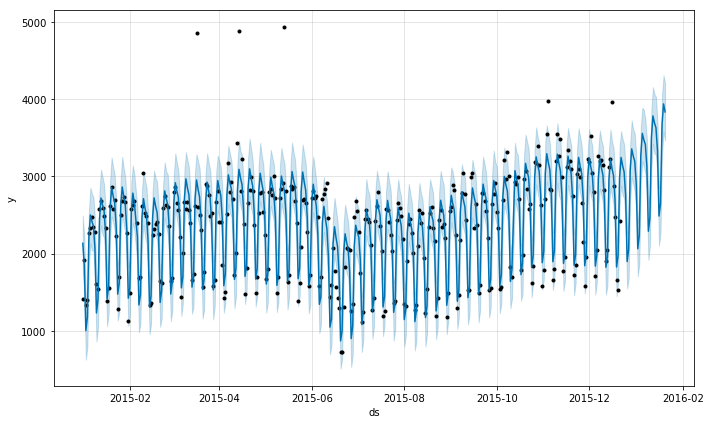

In [10]:
m.plot(forecast)

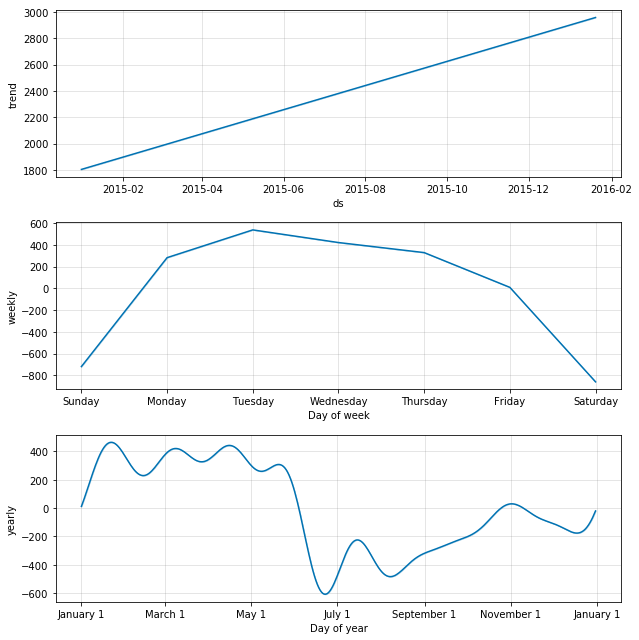

In [11]:
m.plot_components(forecast)

**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

Оценим качество предсказания по последним 30 точкам.

<b>3833<b>

In [12]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2016-01-16,2485.273023,2098.736650,2847.867708,1644
2016-01-17,2645.788700,2270.180024,3004.956025,1836
2016-01-18,3666.218059,3279.426210,4045.721379,2983
2016-01-19,3936.725019,3579.923588,4306.011621,3389
2016-01-20,3832.601123,3460.409094,4206.641659,3559


In [13]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE', np.mean(abs(cmp_df[-predictions:]['p'])))
print('MAE', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE 38.38080483515084
MAE 712.8566846748123


**Вопрос 2**: Какое получилось MAPE? <b>38.38</b>

**Вопрос 3**: Какое получилось MAE? <b>712.86</b>

## Предсказываем с помощью ARIMA

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa as smt
from tqdm import tqdm

/Users/vladimir/app/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

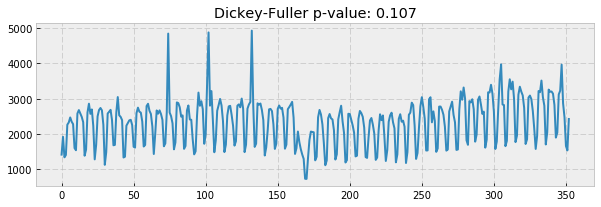

In [15]:
def plotProcess(x):
    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Dickey-Fuller p-value: {}".format(round(sm.tsa.stattools.adfuller(x)[1], 3)))

plotProcess(train_df['y'].values)  

**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?

In [16]:
p = 1
ds = range(0, 2)
q = 2
P = 3
Ds = range(0, 3)
Qs = range(0, 2)

In [17]:
from itertools import product
parameters = product(Ds, ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

12

In [21]:
%%time
from tqdm import tqdm
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=smt.statespace.sarimax.SARIMAX(train_df['y'], order=(p, param[1], q), 
                                        seasonal_order=(P, param[0], param[2], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

100%|██████████| 12/12 [00:00<00:00, 1079.52it/s]

wrong parameters: (0, 0, 0)
wrong parameters: (0, 0, 1)
wrong parameters: (0, 1, 0)
wrong parameters: (0, 1, 1)
wrong parameters: (1, 0, 0)
wrong parameters: (1, 0, 1)
wrong parameters: (1, 1, 0)
wrong parameters: (1, 1, 1)
wrong parameters: (2, 0, 0)
wrong parameters: (2, 0, 1)
wrong parameters: (2, 1, 0)
wrong parameters: (2, 1, 1)
CPU times: user 13.3 ms, sys: 4.82 ms, total: 18.1 ms
Wall time: 14.6 ms
